# Домашняя работа 1


## Описание

В этой домашней работе вы должны применить знания по многослойным нейроным сетям

- Для простоты попробуем обучить сначала однослойный перцептрон
- Решать будем простую задачу бинарной классификации
- Датасет игрушечный -  `load_data()` загружает его


In [ ]:
import numpy as np
import torch
from torch import nn
import sklearn
from sklearn.datasets import make_gaussian_quantiles
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

## Загрузка данных

In [ ]:
def load_data(n_samples=500):
    return make_gaussian_quantiles(
        mean=None,
        cov=0.7,
        n_samples=n_samples,
        n_features=2,
        n_classes=2,
        shuffle=True,
        random_state=42,
    )

In [ ]:
gaussian_quantiles = load_data()
X, y = gaussian_quantiles

print(X[:10, :])
print(y[:10])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

[[-1.13773727  0.62436053]
 [-0.75970745 -1.18161805]
 [-0.82471758  0.42171557]
 [-0.09398039 -0.18487643]
 [-0.80731289  0.57399183]
 [ 0.67980788  1.13471182]
 [-1.70521733 -0.84342552]
 [ 1.57461467  1.12565917]
 [-0.22579357 -0.81889248]
 [ 0.97317262  0.00856159]]
[1 1 0 0 1 1 1 1 0 1]


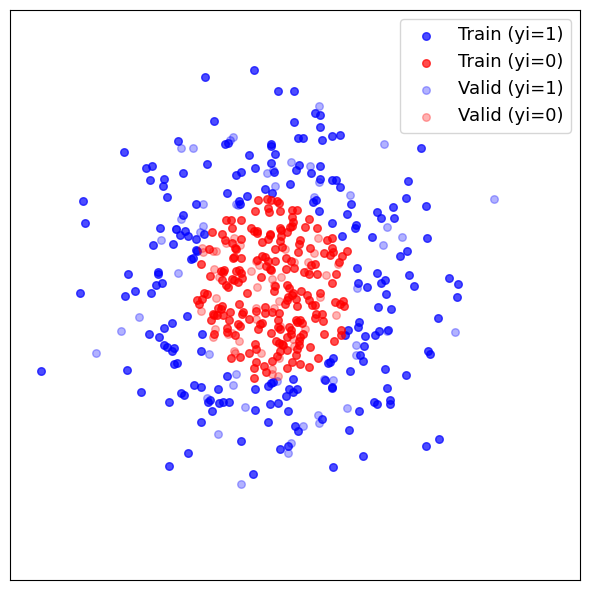

In [ ]:
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def plot_data(X, y, xy_labels=True, label=None, **kwargs):
    X_1 = X[y == 1]
    X_0 = X[y == 0]
    if label is not None:
        plt.scatter(X_1[:, 0], X_1[:, 1], c="blue", s=30, label=label + " (yi=1)", **kwargs)
        plt.scatter(X_0[:, 0], X_0[:, 1], c="red", s=30, label=label + " (yi=0)", **kwargs)
    plt.xticks(())
    plt.yticks(())
    plt.xlim(X[:, 0].min() - 1, X[:, 0].max() + 1)
    plt.ylim(X[:, 1].min() - 1, X[:, 1].max() + 1)

plt.figure(figsize=(6, 6))
plot_data(X_train, y_train, alpha=0.7, label="Train")
plot_data(X_test, y_test, alpha=0.3, label="Valid")
plt.legend(fontsize=13)
plt.tight_layout()

## Класс нейросети

Вам необходимо описать простую полносвязную многослойную нейронную сеть

>💖 Проверю, сколько у меня образцов (строки - первое число) и сколько признаков (столбцы - второе число). Это надо, чтобы прописать входной размер на первом слое.
>
> Большинство значений отрицательные, поэтому буду использовать функцию активации Leaky ReLU сначала. А вконце на выходе Tanh.
>
> Глобальная идея такая:
>
>1) Разбить данные на train и test + перевести в тензоры перед обучением (пунктом 4)
>
>2) Описать слои нейросетки
>
>3) Описать, как будет обучаться модель
>
>4) Для разных оптимизаторов запустить циклы обучения модели
>
>5) Менять параметры обучения так, чтобы получались минимальные значения функции потерь

In [ ]:
X.shape

(500, 2)

In [ ]:
(X < 0).sum()

490

In [ ]:
class NeuralNetwork(nn.Module): #наследование классов
    def __init__(self):
        super().__init__() #инициализация родительского класса (это просто надо всегда писать)
        self.layer1 = nn.Linear(2, 10)
        self.act1 = nn.LeakyReLU()
        self.output = nn.Linear(10, 1)
        self.Sigmoid = nn.Sigmoid()

    def forward(self, X):
        x = self.act1(self.layer1(X))
        x = self.Sigmoid(self.output(x))
        return x

##  Функция обучения сети

Необходимо сохранять историю лоссов для последующего сравнения и визуализации.
Также нужно реализовать early stopping. Критерий остановки подбирите на ваше усмотрение.

In [ ]:
X_train[0:5]

array([[ 0.52347086, -0.71714946],
       [-1.32518818,  0.63620855],
       [ 1.20585575, -1.20132847],
       [-0.5126958 , -0.3243744 ],
       [ 0.01165408, -0.0201845 ]])

In [ ]:
y_train[0:5]

array([0, 1, 1, 0, 0])

In [ ]:
#пропишу все библиотеки, которые здесь использую
import copy
import torch.nn as nn
import torch.optim as optim
import numpy as np


def train(model, loss, opt, n_epochs, batch_size,
          X_train, y_train, X_test, y_test, bad_times):

    best_acc = 0 #бесконечно большое число
    best_weights = None
    loss_history = []
    bad_times_counter = 0

    model.train() #режим обучения модели

    for epoch in range(n_epochs):
        for start in range(0, len(X_train), batch_size): #проходим по всем батчам
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            y_pred = model(X_batch).squeeze()
            loss_fn = loss(y_pred, y_batch)
            loss_fn.backward() #вычисление градиентов
            opt.step() #обновление весов
            opt.zero_grad() #обнуление градиентов

        model.eval() #режим оценки модели
        y_pred = model(X_test).squeeze()
        acc = (y_pred.round() == y_test).float().mean()
        loss_epoch = loss(y_pred, y_test)
        loss_epoch = float(loss_epoch)
        loss_history.append(loss_epoch)

        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
            bad_times_counter = 0
        else:
            bad_times_counter += 1

        if bad_times_counter > bad_times:
            print('Приплыли')
            break


    return best_weights, best_acc, loss_history

### Обучите сеть

Обучите сеть три раза - с тремя разными оптимизиторами
Не забудьте переинициализировать сеть заного перед каждой загрузкой. Убедитесь, что вы верно передали параметры сети в оптимизатор

**Подсказка** Лучше объявить три независимых объекта - модель1, модель2 и модель3

In [ ]:
X_train_torch = torch.from_numpy(X_train).float()
y_train_torch = torch.from_numpy(y_train).float()
X_test_torch = torch.from_numpy(X_test).float()
y_test_torch = torch.from_numpy(y_test).float()

models = [NeuralNetwork() for i in range(3)]

optims = {
    'SGD': (optim.SGD(models[0].parameters(), lr=0.001), 0),
    'Adam': (optim.Adam(models[1].parameters(), lr=0.001), 1),
    'RMSProp': (optim.RMSprop(models[2].parameters(), lr=0.001), 2)
}

best_acc_dict = {}
loss_history_dict = {}

for opt_name, (opt, i) in optims.items():

    best_weights, best_acc, loss_history = train(model = models[i], loss = nn.BCELoss(), opt = opt,
                                      n_epochs = 1000, batch_size = 40,
                                      X_train = X_train_torch, y_train = y_train_torch,
                                      X_test = X_test_torch, y_test = y_test_torch,
                                      bad_times = 100)

    best_acc_dict[opt_name] = best_acc
    loss_history_dict[opt_name] = loss_history

    print(f"Лучшая accuracy: {best_acc} для оптимизатора {opt_name}")

Приплыли
Лучшая accuracy: 0.8199999928474426 для оптимизатора SGD
Приплыли
Лучшая accuracy: 0.9700000286102295 для оптимизатора Adam
Приплыли
Лучшая accuracy: 0.9900000095367432 для оптимизатора RMSProp


### А теперь посмотрим на графики лоссов

In [ ]:
best_acc_dict

{'SGD': tensor(0.8200), 'Adam': tensor(0.9700), 'RMSProp': tensor(0.9900)}

In [ ]:
loss_SGD = loss_history_dict['SGD']
loss_Adam = loss_history_dict['Adam']
loss_RMSProp = loss_history_dict['RMSProp']

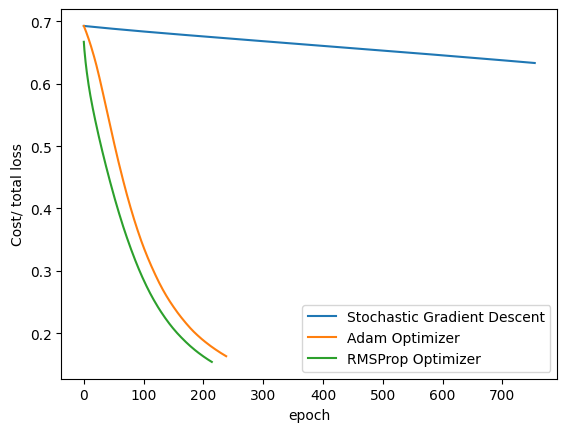

In [ ]:
plt.plot(loss_SGD, label = "Stochastic Gradient Descent")
plt.plot(loss_Adam, label = "Adam Optimizer")
plt.plot(loss_RMSProp, label = 'RMSProp Optimizer')
plt.xlabel('epoch')
plt.ylabel('Cost/ total loss')
plt.legend()
plt.show()

>💖 Лучше всего модель обучилась с RMSProp Optimizer.
>
> Я подобрала такие параметры:  `lr = 0.001`, `n_epochs = 20000`, `batch_size = 30`, `bad_times = 1000`.

### Инициализация

Теперь проинициализируйте веса в вашей модели: случайно и Ксавьером. Сравните эти две модели на предыдущей задаче.

In [ ]:
class RandomNetwork(nn.Module): #наследование классов

    def __init__(self):
        super().__init__() #инициализация родительского класса (это просто надо всегда писать)

        self.layer1 = nn.Linear(2, 10)
        self.act1 = nn.LeakyReLU()
        self.output = nn.Linear(10, 1)
        self.Sigmoid = nn.Sigmoid()

        self.initialize_weights()


    def initialize_weights(self):
        self.layer1.weight = nn.Parameter(torch.tensor(np.random.uniform(-1, 1, (10, 2)), dtype=torch.float32))
        self.layer1.bias = nn.Parameter(torch.tensor(np.random.uniform(-1, 1, (10)), dtype=torch.float32))
        self.output.weight = nn.Parameter(torch.tensor(np.random.uniform(-1, 1, (1, 10)), dtype=torch.float32))
        self.output.bias = nn.Parameter(torch.tensor(np.random.uniform(-1, 1, (1)), dtype=torch.float32))


    def forward(self, X):
        x = self.act1(self.layer1(X))
        x = self.Sigmoid(self.output(x))
        return x

>💖 Теорию по инициализации весов Ксавьером нашла здесь.
>
>Нормализованный метод инициализации Ксавье вычисляется как случайное число с равномерным распределением вероятностей (U) между диапазоном -(sqrt(6)/sqrt(n + m)) и sqrt(6)/sqrt(n + m), где n — количество входов в узел (например, количество узлов в предыдущем слое), а m — количество выходов из уровня (например, количество узлов в текущем слое).
>
>Weight = U[-(sqrt(6)/sqrt(n + m)), sqrt(6)/sqrt(n + m)]

In [ ]:
import math

class XavierNetwork(nn.Module): #наследование классов

    def __init__(self):
        super().__init__() #инициализация родительского класса (это просто надо всегда писать)

        self.layer1 = nn.Linear(2, 10)
        self.act1 = nn.LeakyReLU()
        self.output = nn.Linear(10, 1)
        self.Sigmoid = nn.Sigmoid()

        self.initialize_weights()


    def initialize_weights(self):
        mean = 0
        std = (math.sqrt(6)/math.sqrt(2 + 10))

        self.layer1.weight = nn.Parameter(torch.tensor(np.random.normal(mean, std, (10, 2)), dtype=torch.float32))
        self.layer1.bias = nn.Parameter(torch.tensor(np.zeros(10), dtype=torch.float32))
        self.output.weight = nn.Parameter(torch.tensor(np.random.normal(mean, std, (1, 10)), dtype=torch.float32))
        self.output.bias = nn.Parameter(torch.tensor(np.zeros(1), dtype=torch.float32))


    def forward(self, X):
        x = self.act1(self.layer1(X))
        x = self.Sigmoid(self.output(x))
        return x

>💖 Тест модели с **рандомной** инициализацией весов

In [ ]:
models = [RandomNetwork() for i in range(3)]

optims = {
    'SGD': (optim.SGD(models[0].parameters(), lr=0.001), 0),
    'Adam': (optim.Adam(models[1].parameters(), lr=0.001), 1),
    'RMSProp': (optim.RMSprop(models[2].parameters(), lr=0.001), 2)
}

best_acc_dict = {}
loss_history_dict = {}

for opt_name, (opt, i) in optims.items():

    best_weights, best_acc, loss_history = train(model = models[i], loss = nn.BCELoss(), opt = opt,
                                      n_epochs = 1000, batch_size = 30,
                                      X_train = X_train_torch, y_train = y_train_torch,
                                      X_test = X_test_torch, y_test = y_test_torch,
                                      bad_times = 100)

    best_acc_dict[opt_name] = best_acc
    loss_history_dict[opt_name] = loss_history

    print(f"Лучшая accuracy: {best_acc} для оптимизатора {opt_name}")

Приплыли
Лучшая accuracy: 0.949999988079071 для оптимизатора SGD
Приплыли
Лучшая accuracy: 0.9599999785423279 для оптимизатора Adam
Приплыли
Лучшая accuracy: 0.9900000095367432 для оптимизатора RMSProp


In [ ]:
best_acc_dict

{'SGD': tensor(0.9500), 'Adam': tensor(0.9600), 'RMSProp': tensor(0.9900)}

>💖 Тест модели с инициализацией весов **по Ксавьеру**

In [ ]:
models = [XavierNetwork() for i in range(3)]

optims = {
    'SGD': (optim.SGD(models[0].parameters(), lr=0.001), 0),
    'Adam': (optim.Adam(models[1].parameters(), lr=0.001), 1),
    'RMSProp': (optim.RMSprop(models[2].parameters(), lr=0.001), 2)
}

best_acc_dict = {}
loss_history_dict = {}

for opt_name, (opt, i) in optims.items():

    best_weights, best_acc, loss_history = train(model = models[i], loss = nn.BCELoss(), opt = opt,
                                      n_epochs = 1000, batch_size = 30,
                                      X_train = X_train_torch, y_train = y_train_torch,
                                      X_test = X_test_torch, y_test = y_test_torch,
                                      bad_times = 100)

    best_acc_dict[opt_name] = best_acc
    loss_history_dict[opt_name] = loss_history

    print(f"Лучшая accuracy: {best_acc} для оптимизатора {opt_name}")

Приплыли
Лучшая accuracy: 0.4699999988079071 для оптимизатора SGD
Приплыли
Лучшая accuracy: 0.9700000286102295 для оптимизатора Adam
Приплыли
Лучшая accuracy: 0.9800000190734863 для оптимизатора RMSProp


In [ ]:
best_acc_dict

{'SGD': tensor(0.4700), 'Adam': tensor(0.9700), 'RMSProp': tensor(0.9800)}

>💖 **СРАВНЕНИЕ ЛУЧШИХ MSE** 💖

> **Изначальная модель:**
>
> ```
{'SGD': tensor(0.8200),
 'Adam': tensor(0.9700),
 'RMSProp': tensor(0.9900)}
```

>**Модель с рандомной инициализацией весов:**
> ```
{'SGD': tensor(0.9500),
 'Adam': tensor(0.9600),
 'RMSProp': tensor(0.9900)}
```
>
>**Модель с инициализацией весов по Ксавьеру:**
> ```
{'SGD': tensor(0.4700),
 'Adam': tensor(0.9700),
 'RMSProp': tensor(0.9800)}
```

>**Вывод:**
>
> Обучение модели зависит от исходной инициализации весов. В этом случае рандомная инициализация (то, как я ее организовала) привела к наилучшей точности предсказания для всех моделей.

## А теперь решите многоклассовую проблему

Продемонстрируйте свои знания - решите более сложную проблему
Попробуйте разные инициализации, методы оптимизации и кол-во нейронов.

**Найдите лучшие параметры через KFold**

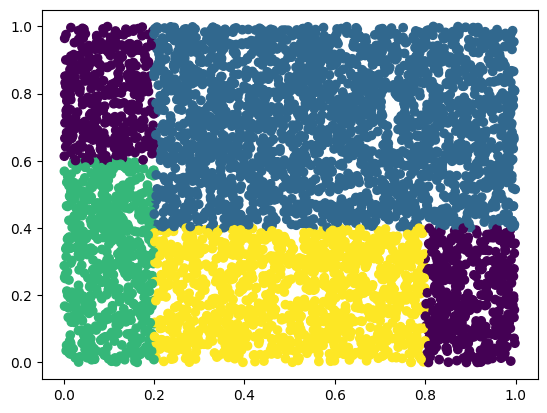

In [ ]:
points = torch.rand(5000,2)
target = []
for p in points:
    if p[0]>0.2 and p[1]>0.4:
        target.append(1)
    elif p[0]<0.2 and p[1]<0.6:
        target.append(2)
    elif p[0]>0.2 and p[0]<0.8 and p[1] < 0.5:
        target.append(3)
    else:
        target.append(0)

target = torch.FloatTensor(target)
data = torch.as_tensor(np.column_stack((points,target)))

train = data[:800]
valid = data[800:900]
test = data[900:]

plt.scatter(data[:,0],data[:,1],c = data[:,2])
plt.show()

>💖 Спасибо. Это красиво.
>
>Получили 5000 точек в 2D пространстве. Точки разбиты на 4 класса (0, 1, 2, 3).

In [ ]:
data

tensor([[0.8677, 0.9424, 1.0000],
        [0.0395, 0.4467, 2.0000],
        [0.2484, 0.8848, 1.0000],
        ...,
        [0.2894, 0.7961, 1.0000],
        [0.9543, 0.8370, 1.0000],
        [0.1060, 0.3608, 2.0000]])

In [ ]:
class AdvancedModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = nn.Linear(2, 200)
        self.bn1 = nn.BatchNorm1d(200)
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)

        self.layer2 = nn.Linear(200, 20)
        self.bn2 = nn.BatchNorm1d(20)
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.1)

        self.output = nn.Linear(20, 4)

        self.initialize_weights()


    def initialize_weights(self): # По Ксавьеру
        nn.init.xavier_normal_(self.layer1.weight)
        nn.init.constant_(self.layer1.bias, 0)

        nn.init.xavier_normal_(self.layer2.weight)
        nn.init.constant_(self.layer2.bias, 0)

        nn.init.xavier_normal_(self.output.weight)
        nn.init.constant_(self.output.bias, 0)


    def forward(self, X):
        x = self.dropout1(self.act1(self.bn1(self.layer1(X))))
        x = self.dropout2(self.act2(self.bn2(self.layer2(x))))
        x = self.output(x)

        return x

In [ ]:
import torch.nn.functional as F

In [ ]:
train = data[:800]
valid = data[800:900]
test = data[900:]

X_train_torch = train[:, 0:2]
y_train_torch = train[:, 2]
X_test_torch = test[:, 0:2]
y_test_torch = test[:, 2]
X_valid_torch = valid[:, 0:2]
y_valid_torch = valid[:, 2]

X_train = X_train_torch.numpy()
y_train = y_train_torch.numpy()
X_test = X_test_torch.numpy()
y_test = y_test_torch.numpy()
X_valid = X_valid_torch.numpy()
y_valid = y_valid_torch.numpy()

X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

y_train_long = y_train_torch.long()
y_test_long = y_test_torch.long()

# y в формате One-Hot-Encoding
y_train_onehot = np.reshape(F.one_hot(y_train_torch.to(torch.int64), num_classes=4), (800,4))
y_test_onehot = np.reshape(F.one_hot(y_test_torch.to(torch.int64), num_classes=4),(4100,4))
y_valid_onehot = np.reshape(F.one_hot(y_valid_torch.to(torch.int64), num_classes=4),(100,4))

In [ ]:
X_train_torch

tensor([[0.8677, 0.9424],
        [0.0395, 0.4467],
        [0.2484, 0.8848],
        ...,
        [0.5719, 0.3818],
        [0.2683, 0.5476],
        [0.7234, 0.6075]])

In [ ]:
def train(model, loss, opt, n_epochs, batch_size,
          X_train, y_train, X_test, y_test, bad_times):

    best_acc = 0 #бесконечно большое число
    best_weights = None
    loss_history = []
    bad_times_counter = 0

    model.train() #режим обучения модели

    for epoch in range(n_epochs):
        for start in range(0, len(X_train), batch_size): #проходим по всем батчам
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            y_pred = model(X_batch)
            loss_fn = loss(y_pred, y_batch.float())
            loss_fn.backward() #вычисление градиентов
            opt.step() #обновление весов
            opt.zero_grad() #обнуление градиентов

        model.eval() #режим оценки модели
        y_pred = model(X_test)
        y_pred_classes = y_pred.argmax(dim=1)
        y_pred_classes = F.one_hot(y_pred_classes.to(torch.int64), num_classes=4)
        acc = (y_pred_classes == y_test).float().mean().item()

        loss_epoch = loss(y_pred, y_test.float())
        loss_epoch = float(loss_epoch)
        loss_history.append(loss_epoch)

        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
            bad_times_counter = 0
        else:
            bad_times_counter += 1

        if bad_times_counter > bad_times:
            print('Приплыли')
            break

    return best_weights, best_acc, loss_history

>💖 Сначала протестировала без KFold и без подбора параметров, чтобы выловить и исправить все ошибки.

In [ ]:
model = AdvancedModel()
opt = optim.Adam(model.parameters())


best_weights, best_acc, history = train(model = model, loss = nn.CrossEntropyLoss(), opt = opt,
                                                n_epochs = 100, batch_size = 10,
                                                X_train = X_train_torch, y_train = y_train_onehot,
                                                X_test = X_test_torch, y_test = y_test_onehot,
                                                bad_times = 10)

print(f"Лучший Accuracy: {best_acc} для оптимизатора Adam")

Приплыли
Лучший Accuracy: 0.980731725692749 для оптимизатора Adam


In [ ]:
from sklearn.model_selection import KFold

In [ ]:
# Инфу про KFold нашла тут: https://www.kaggle.com/code/satishgunjal/tutorial-k-fold-cross-validation

kf = KFold(n_splits=5, shuffle=True, random_state=42)

i = 0

for train_index, test_index in kf.split(X, y):
    print(f'Fold:{i}, Train set: {len(train_index)}, Test set:{len(test_index)}')
    i += 1

Fold:0, Train set: 3920, Test set:980
Fold:1, Train set: 3920, Test set:980
Fold:2, Train set: 3920, Test set:980
Fold:3, Train set: 3920, Test set:980
Fold:4, Train set: 3920, Test set:980


>💖 Придумала способ хранения инфы о разбиении данных с помощью KFold в списках (код ниже).

In [ ]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)

X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []

for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    X_train = torch.from_numpy(X_train)
    X_test = torch.from_numpy(X_test)
    y_train = torch.from_numpy(y_train)
    y_test = torch.from_numpy(y_test)

    y_train = F.one_hot(y_train.to(torch.int64), num_classes=4)
    y_test = F.one_hot(y_test.to(torch.int64), num_classes=4)

    X_train_list.append(X_train)
    X_test_list.append(X_test)
    y_train_list.append(y_train)
    y_test_list.append(y_test)

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits = 3, shuffle=True, random_state=42)

models = [AdvancedModel() for i in range(4)]

optims = {
    'Adam, lr = 0.01': (optim.Adam(models[0].parameters(), lr=0.01), 0),
    'RMSProp, lr = 0.01': (optim.RMSprop(models[1].parameters(), lr=0.01), 1),
    'Adam, lr = 0.001': (optim.Adam(models[2].parameters(), lr=0.001), 2),
    'RMSProp, lr = 0.001': (optim.RMSprop(models[3].parameters(), lr=0.001), 3),
}

fold = 0

best_acc_dict = {}
history_dict = {}

X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []

batch_sizes = [10, 20, 30]

for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    X_train = torch.from_numpy(X_train)
    X_test = torch.from_numpy(X_test)
    y_train = torch.from_numpy(y_train)
    y_test = torch.from_numpy(y_test)

    y_train = F.one_hot(y_train.to(torch.int64), num_classes=4)
    y_test = F.one_hot(y_test.to(torch.int64), num_classes=4)

    X_train_list.append(X_train)
    X_test_list.append(X_test)
    y_train_list.append(y_train)
    y_test_list.append(y_test)

    batch_size = batch_sizes[fold]
    X_train = X_train_list[fold]
    X_test = X_test_list[fold]
    y_train = y_train_list[fold]
    y_test = y_test_list[fold]


    for opt_name, (opt, j) in optims.items():


        best_weights, best_acc, history = train(model = models[j], loss = nn.CrossEntropyLoss(), opt = opt,
                                                n_epochs = 15, batch_size = batch_size,
                                                X_train = X_train, y_train = y_train,
                                                X_test = X_test, y_test = y_test,
                                                bad_times = 5)

        best_acc_dict[(opt_name, i)] = best_acc
        history_dict[(opt_name, i)] = history


        print(f"Набор фолдов № {fold + 1}")
        print(f"Лучший Accuracy: {best_acc}, оптимизатор {opt_name}, batch size = {batch_size}")


    fold += 1


Приплыли
Набор фолдов № 1
Лучший Accuracy: 0.9813341498374939, оптимизатор Adam, lr = 0.01, batch size = 10
Приплыли
Набор фолдов № 1
Лучший Accuracy: 0.9847001433372498, оптимизатор RMSProp, lr = 0.01, batch size = 10
Набор фолдов № 1
Лучший Accuracy: 0.984088122844696, оптимизатор Adam, lr = 0.001, batch size = 10
Приплыли
Набор фолдов № 1
Лучший Accuracy: 0.9868420958518982, оптимизатор RMSProp, lr = 0.001, batch size = 10
Приплыли
Набор фолдов № 2
Лучший Accuracy: 0.9941824674606323, оптимизатор Adam, lr = 0.01, batch size = 20
Набор фолдов № 2
Лучший Accuracy: 0.9776484966278076, оптимизатор RMSProp, lr = 0.01, batch size = 20
Набор фолдов № 2
Лучший Accuracy: 0.99234539270401, оптимизатор Adam, lr = 0.001, batch size = 20
Набор фолдов № 2
Лучший Accuracy: 0.9800979495048523, оптимизатор RMSProp, lr = 0.001, batch size = 20
Приплыли
Набор фолдов № 3
Лучший Accuracy: 0.9883649945259094, оптимизатор Adam, lr = 0.01, batch size = 30
Приплыли
Набор фолдов № 3
Лучший Accuracy: 0.983772

>💖 Итак, с помощью разбиения выборки на разные train и test подвыборки, можно отметить, что лучший вариант - это `Лучший Accuracy: 0.9941824674606323, оптимизатор Adam, lr = 0.01, batch size = 20`.
>
> По хорошему теперь следует обучить модель на всех данных, но так как это учебное задание, я обучу модель на X_train, который и был изначально.

In [ ]:
model = AdvancedModel()
opt = optim.Adam(model.parameters(), lr=0.01)


best_weights, best_acc, history = train(model = model, loss = nn.CrossEntropyLoss(), opt = opt,
                                                n_epochs = 15, batch_size = 30,
                                                X_train = X_train_torch, y_train = y_train_onehot,
                                                X_test = X_test_torch, y_test = y_test_onehot,
                                                bad_times = 5)

print(f"Лучший Accuracy: {best_acc} для оптимизатора Adam, lr = 0.01, batch size = 20.")

Лучший Accuracy: 0.9825609922409058 для оптимизатора Adam, lr = 0.01, batch size = 20.


## (Почти) Боевая задача

Перед вами датасет с классификацией алкоголя. Продемонстрируйте свои знания и решите задачу многоклассовой классификации

In [ ]:
import numpy as np
import torch
from torch import nn
import sklearn
from sklearn.datasets import make_gaussian_quantiles
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import copy
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
import math

In [ ]:
df = sklearn.datasets.load_wine(as_frame=True)
df = df.frame
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  targe

In [ ]:
df['target'].unique()

array([0, 1, 2])

In [ ]:
#перемешаю строки, чтобы сделать нормальное разбиение на train и test
shuffled_df = df.sample(frac=1, random_state=42).reset_index(drop=True)
shuffled_df

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,13.64,3.10,2.56,15.2,116.0,2.70,3.03,0.17,1.66,5.10,0.96,3.36,845.0,0
1,14.21,4.04,2.44,18.9,111.0,2.85,2.65,0.30,1.25,5.24,0.87,3.33,1080.0,0
2,12.93,2.81,2.70,21.0,96.0,1.54,0.50,0.53,0.75,4.60,0.77,2.31,600.0,2
3,13.73,1.50,2.70,22.5,101.0,3.00,3.25,0.29,2.38,5.70,1.19,2.71,1285.0,0
4,12.37,1.17,1.92,19.6,78.0,2.11,2.00,0.27,1.04,4.68,1.12,3.48,510.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.86,1.51,2.67,25.0,86.0,2.95,2.86,0.21,1.87,3.38,1.36,3.16,410.0,1
174,12.25,1.73,2.12,19.0,80.0,1.65,2.03,0.37,1.63,3.40,1.00,3.17,510.0,1
175,14.38,1.87,2.38,12.0,102.0,3.30,3.64,0.29,2.96,7.50,1.20,3.00,1547.0,0
176,12.69,1.53,2.26,20.7,80.0,1.38,1.46,0.58,1.62,3.05,0.96,2.06,495.0,1


In [ ]:
#из shuffled_df сделеаю матрицы и тензоры для DATA и TARGET, затем TARGET закодирую в ONE HOT ENCODING

data_matrix = np.array(shuffled_df.iloc[:, 0:13])
data_tensor = torch.from_numpy(data_matrix).float()

target_matrix = np.array(shuffled_df['target'])
target_tensor = torch.from_numpy(target_matrix).float()

target_onehot = F.one_hot(target_tensor.to(torch.int64), num_classes=3)

#разобью DATA и TARGET на train (80%) и test (20%)

X_train, X_test, y_train, y_test = train_test_split(data_tensor, target_onehot, test_size=0.2, random_state=42)

print(f'X_train.shape: {X_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'y_test.shape: {y_test.shape}')

X_train.shape: torch.Size([142, 13])
X_test.shape: torch.Size([36, 13])
y_train.shape: torch.Size([142, 3])
y_test.shape: torch.Size([36, 3])


In [ ]:
# модель
class VineModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = nn.Linear(13, 450)
        self.bn1 = nn.BatchNorm1d(450)
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)

        self.layer2 = nn.Linear(450, 150)
        self.bn2 = nn.BatchNorm1d(150)
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.1)

        self.output = nn.Linear(150, 3)

        self.initialize_weights()


    def initialize_weights(self): # По Ксавьеру
        mean = 0
        std = (math.sqrt(6)/math.sqrt(2 + 10))

        nn.init.xavier_normal_(self.layer1.weight)
        nn.init.constant_(self.layer1.bias, 0)

        nn.init.xavier_normal_(self.layer2.weight)
        nn.init.constant_(self.layer2.bias, 0)

        nn.init.xavier_normal_(self.output.weight)
        nn.init.constant_(self.output.bias, 0)


    def forward(self, X):
        x = self.dropout1(self.act1(self.bn1(self.layer1(X))))
        x = self.dropout2(self.act2(self.bn2(self.layer2(x))))
        x = self.output(x)

        return x

In [ ]:
# функция обучения
def train_classes(model, classes, loss, opt, n_epochs, batch_size,
          X_train, y_train, X_test, y_test, bad_times):

    best_acc = 0 #бесконечно большое число
    best_weights = None
    loss_history = []
    bad_times_counter = 0

    model.train() #режим обучения модели

    for epoch in range(n_epochs):
        for start in range(0, len(X_train), batch_size): #проходим по всем батчам
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size].float()
            y_pred = model(X_batch)
            loss_fn = loss(y_pred, y_batch.float())
            loss_fn.backward() #вычисление градиентов
            opt.step() #обновление весов
            opt.zero_grad() #обнуление градиентов

        model.eval() #режим оценки модели
        y_pred = model(X_test)
        y_pred_classes = y_pred.argmax(dim=1)
        y_pred_classes = F.one_hot(y_pred_classes.to(torch.int64), num_classes=classes)
        acc = (y_pred_classes == y_test).float().mean().item()

        loss_epoch = loss(y_pred, y_test.float())
        loss_epoch = float(loss_epoch)
        loss_history.append(loss_epoch)

        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
            bad_times_counter = 0
        else:
            bad_times_counter += 1

        if bad_times_counter > bad_times:
            print('Приплыли')
            break

    return best_weights, best_acc, loss_history

In [ ]:
# обучение
model = VineModel()
opt = optim.RMSprop(model.parameters(), lr=0.001)


best_weights, best_acc, loss_history = train_classes(model = model, classes = 3, loss = nn.CrossEntropyLoss(), opt = opt,
                                                n_epochs = 20, batch_size = 10,
                                                X_train = X_train, y_train = y_train,
                                                X_test = X_test, y_test = y_test,
                                                bad_times = 10)

print(f"Лучший Accuracy: {best_acc} для оптимизатора RMSprop, lr = 0.001, batch_size = 10.")

Лучший Accuracy: 0.9814814925193787 для оптимизатора RMSprop, lr = 0.001, batch_size = 10.
